<a href="https://colab.research.google.com/github/neel26desai/cmpe258_assignment1/blob/main/MediaPipe_GestureDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

Using the Hand gesture recognization model provided by Media Pipe.

First part of the Notebook explore how to use the hand landmark models to identify the landmarks and plot them on the image.

Second part of the Notebook, uses the gesture recognization model on images, and annotated the images with hand landmarks and the detected gesture.

In [ ]:
! pip install mediapipe

In [2]:
#download the model that will be used for gesture recognization
!wget -q https://storage.googleapis.com/mediapipe-models/gesture_recognizer/gesture_recognizer/float16/1/gesture_recognizer.task

In [ ]:
#download the model that will be used for hand landmark detection
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

In [3]:
from matplotlib import pyplot as plt
import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2
import urllib
import cv2
from google.colab.patches import cv2_imshow
import math
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

#Hand LandMark Detection - Image

In [21]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions

In [25]:
import numpy as np

In [13]:
landmark_model_path = '/content/hand_landmarker.task'

#these are just class references
BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

#initializng HandLandmArkerOptions, setting it to run on images
options = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=landmark_model_path),
    running_mode=VisionRunningMode.IMAGE)

#initialize the landmarker, with the set options
with HandLandmarker.create_from_options(options) as landmarker:
  # Load the input image from an image file.
  mp_image = mp.Image.create_from_file('/content/thumbs_up.jpg')
  # Perform hand landmarks detection on the provided single image.
  # The hand landmarker must be created with the image mode.
  hand_landmarker_result = landmarker.detect(mp_image)




In [32]:
def draw_landmarks_on_image(rgb_image,hand_landmarker_result):
  # extracting the list of 21 normalized landmarks
  hand_landmarks_list=hand_landmarker_result.hand_landmarks # we'llhave 21 markers for each hand detected in theimegae
  #find the list of hands detected, i.e. right, left
  handedness_list = hand_landmarker_result.handedness
  annotated_image = np.copy(rgb_image)# copy of the orignal image on which we will makr all the hand markers
  #let us loop through to each of the detected hands to draw the markers on them
  for i in range(len(hand_landmarks_list)):
    # extracting the landmarks and handedness for the ith hand, in the image
    hand_landmarks = hand_landmarks_list[i]
    handedness = handedness_list[i]

    #draw the hand landmarkers
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList() #this object will normalize the landark cordinates based on the image size
    #adding all the landmark to the landmark_pb2 framework
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    MARGIN = 10  # pixels
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # # Draw handedness (left or right hand) on the image.

    # FONT_SIZE = 1
    # FONT_THICKNESS = 1
    # HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green
    # cv2.putText(annotated_image, f"{handedness[0].category_name}",
    #             (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
    #             FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image




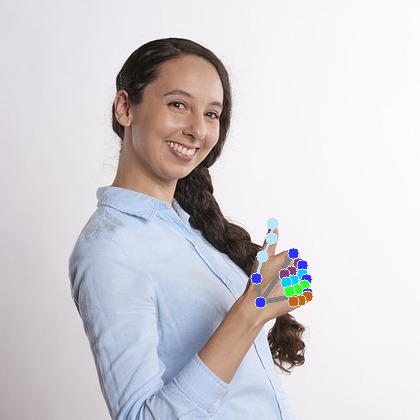

In [33]:
annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), hand_landmarker_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

# Hand Gesture Recognition -Image

Rough work to get an Idea how the flow works

In [48]:
import mediapipe as mp

# Create a gesture recognizer instance with the image mode:
gesture_options = GestureRecognizerOptions(
    base_options=BaseOptions(model_asset_path=gesture_model_path),
    running_mode=VisionRunningMode.IMAGE)

with GestureRecognizer.create_from_options(gesture_options) as recognizer:
  mp_image = mp.Image.create_from_file('/content/thumbs_up.jpg')
  gesture_recognition_result = recognizer.recognize(mp_image)

print(gesture_recognition_result.gestures[0][0].category_name)

## Modular Implementation of Hand Gesture Recognization , along with image annotation with hand landmarks and gestures

In [73]:
def initialize_gesture_model(path='/content/gesture_recognizer.task'):
  '''
  Initialize the Mediapipe gesture model
  path : location where the model gesture_recognizer.task is saved
  '''
  gesture_model_path = '/content/gesture_recognizer.task'

  BaseOptions = mp.tasks.BaseOptions
  GestureRecognizer = mp.tasks.vision.GestureRecognizer
  GestureRecognizerOptions = mp.tasks.vision.GestureRecognizerOptions
  VisionRunningMode = mp.tasks.vision.RunningMode
  # Create a gesture recognizer instance with the image mode, setting up base config
  gesture_options = GestureRecognizerOptions(
    base_options=BaseOptions(model_asset_path=gesture_model_path),
    running_mode=VisionRunningMode.IMAGE)
  #creating  gesture recognizer from the base config
  recognizer=GestureRecognizer.create_from_options(gesture_options)

  return recognizer


def make_prediction(model,image):
  '''
    Will take the gesture recognizer and an Image and will make the gesture prediction on it
    model: of form GestureRecognizer
    image: of form mediapipe.Image
  '''
  gesture_prediction = model.recognize(image)
  return gesture_prediction



def draw_landmarks_and_gesture_on_image(rgb_image,predictions):
  '''
    displayig the result, adding the landmark and gesture prediction to the
    prediction: the prediction received using the gesture recognization model
    rgb_image: numpy representation of the image
  '''
  hand_landmarks_lists = predictions.hand_landmarks
  gestures = predictions.gestures
  annotated_image = rgb_image.copy() #creating a copy of the orignal image on whcih we ca annottare

  #visualization config
  MARGIN = 5  # pixels
  FONT_SIZE = 0.8
  FONT_THICKNESS = 1
  GESTURE_TEXT_COLOR = (88, 205, 54) # vibrant green


  #iterate throught all hands
  for i in range(len(hand_landmarks_lists)):
    #hand landmarks
    hand_landmarks = hand_landmarks_lists[i]
    #detected gestures
    gesture = gestures[i]

    #draw the hand_landmarks
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    #anoote each landmark on the image. mormalize ladmarks normalizes the cordinates based on the image size
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())


    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

     # Draw gesutre (left or right hand) on the image. we put the text on same cordinate as that of the bounding box, we found above
    cv2.putText(annotated_image, f"{gesture[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, GESTURE_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

    return annotated_image



Downloading the images on for testing purpose

In [63]:
#download images that we will use for testing
import urllib

IMAGE_FILENAMES = ['thumbs_down.jpg', 'victory.jpg', 'thumbs_up.jpg', 'pointing_up.jpg']

for name in IMAGE_FILENAMES:
  url = f'https://storage.googleapis.com/mediapipe-tasks/gesture_recognizer/{name}'
  urllib.request.urlretrieve(url, name)

Flow
1. Initialize the model
2. Set Up plt config for visualization
3. Iterate through all image files
4. load image file, pass it for prediction
5. Use the prediction for annotating the image
6. Add the annotated image as subplot


## Implementation of the flow

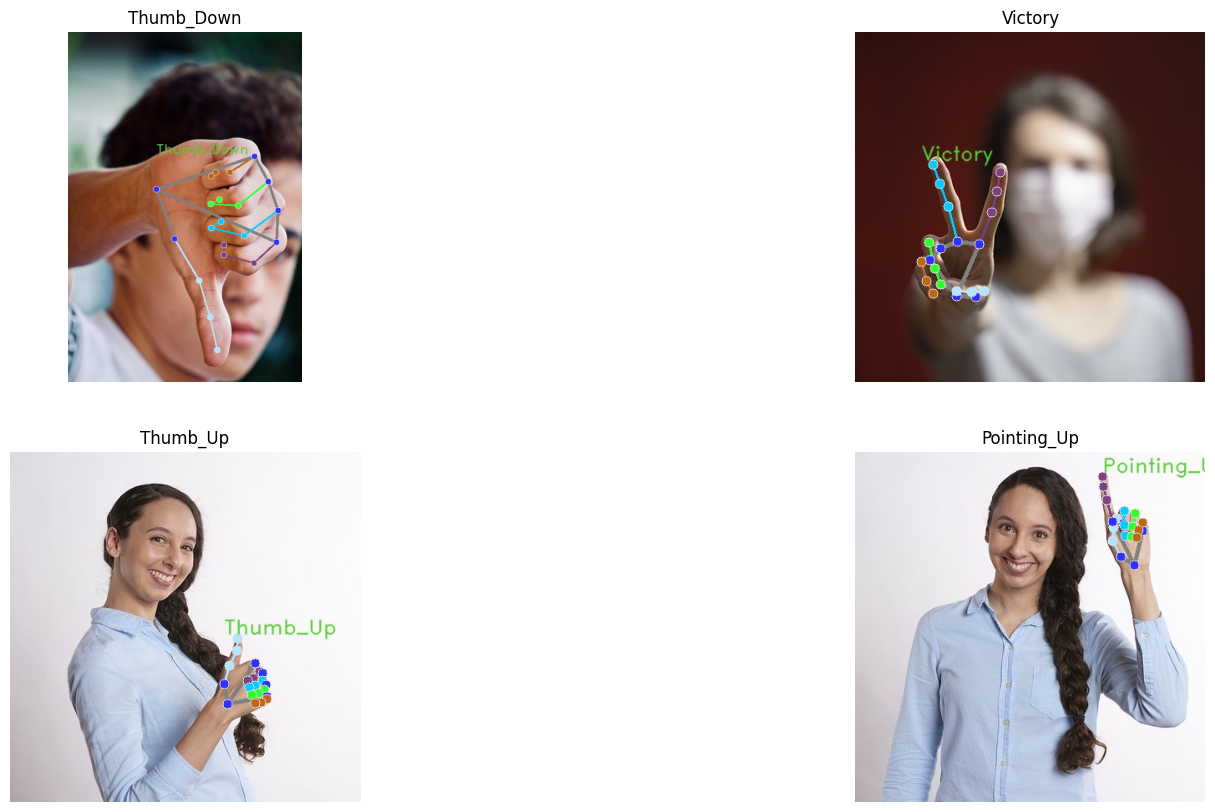

In [74]:
#initialize the gesture model
recognizer = initialize_gesture_model()
#save the annotated in a list
annotated_images =[]
#setting for displaying multiple plots
columns = 2
rows = (len(IMAGE_FILENAMES) + columns - 1) // columns  # Calculate rows needed, round up
plt.figure(figsize=(20, 10))  # Adjust the size as needed
#iterrate through all the images and pass them to the model
for i,img in enumerate(IMAGE_FILENAMES,start=1):
  img = f'/content/{img}'
  #read the image file
  mp_image = mp.Image.create_from_file(img)
  #make prediction on the image file
  gesture_prediction = make_prediction(recognizer,mp_image)
  #make a annotation of the prediction on the image
  annotated_image=draw_landmarks_and_gesture_on_image(mp_image.numpy_view(),gesture_prediction)
  plt.subplot(rows, columns, i)
  plt.imshow(annotated_image)
  plt.title(gesture_prediction.gestures[0][0].category_name)
plt.show()

Reference:
<ol>
<li> https://github.com/googlesamples/mediapipe/blob/main/examples/gesture_recognizer/python/gesture_recognizer.ipynb
<li> https://developers.google.com/mediapipe/solutions/vision/gesture_recognizer#models
<li> https://developers.google.com/mediapipe/api/solutions/java/com/google/mediapipe/tasks/components/containers/NormalizedLandmark
<li> https://colab.research.google.com/github/googlesamples/mediapipe/blob/main/examples/hand_landmarker/python/hand_landmarker.ipynb#scrollTo=OMjuVQiDYJKF&uniqifier=1
<li> https://developers.google.com/mediapipe/solutions/vision/gesture_recognizer/python
</ol>